# Plotting Kullback-Leibler divergence for the distribution of the tumor cell population and fraction

## Import libraries

In [2]:
# %matplotlib notebook
#  add Python-loader repo to the path 
import sys
sys.path.insert(0, '../Python-loader/')
from pyMCDS import pyMCDS

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import scipy.stats as sts
from scipy.integrate import odeint
from scipy.ndimage.filters import gaussian_filter

## Define cell cycle model

In [140]:
# CELL CYCLE MODELS
### advanced_Ki67_cycle_model = 0
### basic_Ki67_cycle_model = 1
### flow_cytometry_cycle_model = 2
### live_apoptotic_cycle_model = 3
### total_cells_cycle_model = 4
### live_cells_cycle_model = 5 
### flow_cytometry_separated_cycle_model = 6
### cycling_quiescent_model = 7
cycle_model = 6

output_folder = "output_Experimental_Settings_R300/"

## Define experimental settings

In [141]:
num_folders = 18
num_params = 3

settings = np.zeros((num_folders, num_params))
settings[0,:] = np.array([6, 100, 10])
settings[1,:] = np.array([6, 100, 20])
settings[2,:] = np.array([6, 100, 50])
settings[3,:] = np.array([6, 100, 100])
settings[4,:] = np.array([6, 100, 200])
settings[5,:] = np.array([6, 100, 300])
settings[6,:] = np.array([6, 500, 10])
settings[7,:] = np.array([6, 500, 20])
settings[8,:] = np.array([6, 500, 50])
settings[9,:] = np.array([6, 500, 100])
settings[10,:] = np.array([6, 500, 200])
settings[11,:] = np.array([6, 500, 300])
settings[12,:] = np.array([6, 1000, 10])
settings[13,:] = np.array([6, 1000, 20])
settings[14,:] = np.array([6, 1000, 50])
settings[15,:] = np.array([6, 1000, 100])
settings[16,:] = np.array([6, 1000, 200])
settings[17,:] = np.array([6, 1000, 300])

## Compute the number of each tumor cell phenotype over all replicates and simulation  times

In [142]:
def get_folder_name(settings):
    if cycle_model == 0:
        folder_name = "output_Ki67_Advanced_"
    elif cycle_model == 1:
        folder_name = "output_Ki67_Basic_"
    elif cycle_model == 2:
        folder_name = "output_Flow_Cytometry_"
    elif cycle_model == 5:
        folder_name = "output_Live_"
    elif cycle_model == 6:
        folder_name = "output_Separated_Flow_Cytometry_"
    else:
        print("Unrecognized cell cycle model.")
    
    if settings[0].is_integer():
        folder_name += "dt" + str(int(settings[0])) + "_NC" + str(int(settings[1])) + "_R" + str(int(settings[2])) + "/"
    else:
        folder_name += "dt" + str(settings[0]) + "_NC" + str(int(settings[1])) + "_R" + str(int(settings[2])) + "/"
    
    return folder_name

In [143]:
last_index = 120;
filename = "PhysiCell_tumor_cell_population.csv";

times = [None] * num_folders; 
if cycle_model == 0:
    Ki67_negative_count = [None] * num_folders; 
    Ki67_positive_premitotic_count = [None] * num_folders; 
    Ki67_positive_postmitotic_count = [None] * num_folders; 
elif cycle_model == 1:
    Ki67_negative_count = [None] * num_folders; 
    Ki67_positive_count = [None] * num_folders; 
elif cycle_model == 2:
    G0G1_phase_count = [None] * num_folders; 
    S_phase_count = [None] * num_folders; 
    G2M_phase_count = [None] * num_folders; 
elif cycle_model == 5:
    live_count = [None] * num_folders; 
elif cycle_model == 6:
    G0G1_phase_count = [None] * num_folders; 
    S_phase_count = [None] * num_folders; 
    G2_phase_count = [None] * num_folders; 
    M_phase_count = [None] * num_folders; 
else:
    print("Unrecognized cell cycle model.")
dead_count = [None] * num_folders; 

for i in range(num_folders):
    num_replicates = int(settings[i,2])
    
    times[i] = np.zeros( last_index+1 ); 
    if cycle_model == 0:
        Ki67_negative_count[i] = np.zeros( (num_replicates, last_index+1) ); 
        Ki67_positive_premitotic_count[i] = np.zeros( (num_replicates, last_index+1) ); 
        Ki67_positive_postmitotic_count[i] = np.zeros( (num_replicates, last_index+1) ); 
    elif cycle_model == 1:
        Ki67_negative_count[i] = np.zeros( (num_replicates, last_index+1) ); 
        Ki67_positive_count[i] = np.zeros( (num_replicates, last_index+1) ); 
    elif cycle_model == 2:
        G0G1_phase_count[i] = np.zeros( (num_replicates, last_index+1) ); 
        S_phase_count[i] = np.zeros( (num_replicates, last_index+1) ); 
        G2M_phase_count[i] = np.zeros( (num_replicates, last_index+1) ); 
    elif cycle_model == 5:
        live_count[i] = np.zeros( (num_replicates, last_index+1) ); 
    elif cycle_model == 6:
        G0G1_phase_count[i] = np.zeros( (num_replicates, last_index+1) ); 
        S_phase_count[i] = np.zeros( (num_replicates, last_index+1) ); 
        G2_phase_count[i] = np.zeros( (num_replicates, last_index+1) ); 
        M_phase_count[i] = np.zeros( (num_replicates, last_index+1) ); 
    else:
        print("Unrecognized cell cycle model.")
    dead_count[i] = np.zeros( (num_replicates, last_index+1) ); 
    
    for id_replicate in range(num_replicates):
        folder_name = output_folder+get_folder_name(settings[i,:])+"output_R"+str("%02d"%id_replicate)+'/'

        data = np.genfromtxt(folder_name + filename, dtype = float, delimiter = ',', names = True)
        times[i][:] = data["times"]
        if cycle_model == 0:
            Ki67_negative_count[i][id_replicate,:] = data["Ki67_negative_num"]
            Ki67_positive_premitotic_count[i][id_replicate,:] = data["Ki67_positive_premitotic_num"]
            Ki67_positive_postmitotic_count[i][id_replicate,:] = data["Ki67_positive_postmitotic_num"]
        elif cycle_model == 1:
            Ki67_negative_count[i][id_replicate,:] = data["Ki67_negative_num"]
            Ki67_positive_count[i][id_replicate,:] = data["Ki67_positive_num"]
        elif cycle_model == 2:
            G0G1_phase_count[i][id_replicate,:] = data["G0G1_phase_num"]
            S_phase_count[i][id_replicate,:] = data["S_phase_premitotic_num"]
            G2M_phase_count[i][id_replicate,:] = data["G2M_phase_postmitotic_num"]
        elif cycle_model == 5:
            live_count[i][id_replicate,:] = data["Live_num"]
        elif cycle_model == 6:
            G0G1_phase_count[i][id_replicate,:] = data["G0G1_phase_num"]
            S_phase_count[i][id_replicate,:] = data["S_phase_premitotic_num"]
            G2_phase_count[i][id_replicate,:] = data["G2_phase_postmitotic_num"]
            M_phase_count[i][id_replicate,:] = data["M_phase_postmitotic_num"]
        else:
            print("Unrecognized cell cycle model.")
        dead_count[i][id_replicate,:] = data["Dead_num"]

## Compute tumor cell fraction over all replicates and simulation times

In [144]:
has_apop_nec = False

if cycle_model == 0:
    Ki67_negative_fraction = [None] * num_folders; 
    Ki67_positive_premitotic_fraction = [None] * num_folders; 
    Ki67_positive_postmitotic_fraction = [None] * num_folders; 
elif cycle_model == 1:
    Ki67_negative_fraction = [None] * num_folders; 
    Ki67_positive_fraction = [None] * num_folders; 
elif cycle_model == 2:
    G0G1_phase_fraction = [None] * num_folders; 
    S_phase_fraction = [None] * num_folders; 
    G2M_phase_fraction = [None] * num_folders; 
elif cycle_model == 5:
    live_fraction = [None] * num_folders; 
elif cycle_model == 6:
    G0G1_phase_fraction = [None] * num_folders; 
    S_phase_fraction = [None] * num_folders; 
    G2_phase_fraction = [None] * num_folders; 
    M_phase_fraction = [None] * num_folders; 
else:
    print("Unrecognized cell cycle model.")

if has_apop_nec:
    apoptotic_fraction = [None] * num_folders; 
    necrotic_fraction = [None] * num_folders; 
else:
    dead_fraction = [None] * num_folders; 
    
for i in range(num_folders):
    num_replicates = int(settings[i,2])
    
    if cycle_model == 0:
        Ki67_negative_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
        Ki67_positive_premitotic_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
        Ki67_positive_postmitotic_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
    elif cycle_model == 1:
        Ki67_negative_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
        Ki67_positive_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
    elif cycle_model == 2:
        G0G1_phase_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
        S_phase_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
        G2M_phase_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
    elif cycle_model == 5:
        live_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
    elif cycle_model == 6:
        G0G1_phase_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
        S_phase_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
        G2_phase_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
        M_phase_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
    else:
        print("Unrecognized cell cycle model.")

    if has_apop_nec:
        apoptotic_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
        necrotic_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
    else:
        dead_fraction[i] = np.zeros( (num_replicates, last_index+1) ); 
        
    for id_replicate in range(num_replicates):
        if cycle_model == 0:
            total_count = Ki67_negative_count[i][id_replicate,:] + Ki67_positive_premitotic_count[i][id_replicate,:] + Ki67_positive_postmitotic_count[i][id_replicate,:];
            total_count += apoptotic_count[i][id_replicate,:] + necrotic_count[i][id_replicate,:] if has_apop_nec else dead_count[i][id_replicate,:];

            Ki67_negative_fraction[i][id_replicate,:] = Ki67_negative_count[i][id_replicate,:]/total_count;
            Ki67_positive_premitotic_fraction[i][id_replicate,:] = Ki67_positive_premitotic_count[i][id_replicate,:]/total_count;
            Ki67_positive_postmitotic_fraction[i][id_replicate,:] = Ki67_positive_postmitotic_count[i][id_replicate,:]/total_count;
        elif cycle_model == 1:
            total_count = Ki67_negative_count[i][id_replicate,:] + Ki67_positive_count[i][id_replicate,:];
            total_count += apoptotic_count[i][id_replicate,:] + necrotic_count[i][id_replicate,:] if has_apop_nec else dead_count[i][id_replicate,:];

            Ki67_negative_fraction[i][id_replicate,:] = Ki67_negative_count[i][id_replicate,:]/total_count;
            Ki67_positive_fraction[i][id_replicate,:] = Ki67_positive_count[i][id_replicate,:]/total_count;
        elif cycle_model == 2:
            total_count = G0G1_phase_count[i][id_replicate,:] + S_phase_count[i][id_replicate,:] + G2M_phase_count[i][id_replicate,:];
            total_count += apoptotic_count[i][id_replicate,:] + necrotic_count[i][id_replicate,:] if has_apop_nec else dead_count[i][id_replicate,:];

            G0G1_phase_fraction[i][id_replicate,:] = G0G1_phase_count[i][id_replicate,:]/total_count;
            S_phase_fraction[i][id_replicate,:] = S_phase_count[i][id_replicate,:]/total_count;
            G2M_phase_fraction[i][id_replicate,:] = G2M_phase_count[i][id_replicate,:]/total_count;
        elif cycle_model == 5:
            total_count = live_count[i][id_replicate,:];
            total_count += apoptotic_count[i][id_replicate,:] + necrotic_count[i][id_replicate,:] if has_apop_nec else dead_count[i][id_replicate,:];

            live_fraction[i][id_replicate,:] = live_count[i][id_replicate,:]/total_count;
        elif cycle_model == 6:
            total_count = G0G1_phase_count[i][id_replicate,:] + S_phase_count[i][id_replicate,:] + G2_phase_count[i][id_replicate,:] + M_phase_count[i][id_replicate,:];
            total_count += apoptotic_count[i][id_replicate,:] + necrotic_count[i][id_replicate,:] if has_apop_nec else dead_count[i][id_replicate,:];

            G0G1_phase_fraction[i][id_replicate,:] = G0G1_phase_count[i][id_replicate,:]/total_count;
            S_phase_fraction[i][id_replicate,:] = S_phase_count[i][id_replicate,:]/total_count;
            G2_phase_fraction[i][id_replicate,:] = G2_phase_count[i][id_replicate,:]/total_count;
            M_phase_fraction[i][id_replicate,:] = M_phase_count[i][id_replicate,:]/total_count;
        else:
            print("Unrecognized cell cycle model.")

        if has_apop_nec:
            apoptotic_fraction[i][id_replicate,:] = apoptotic_count[i][id_replicate,:]/total_count;
            necrotic_fraction[i][id_replicate,:] = necrotic_count[i][id_replicate,:]/total_count;
        else:
            dead_fraction[i][id_replicate,:] = dead_count[i][id_replicate,:]/total_count;

## Solve true model numerically

In [145]:
true_solution = [None] * num_folders

if cycle_model == 0:
    def true_model(X, t, r01, r10, r12, r20):
        Ki67_neg, Ki67_pos_pre, Ki67_pos_post = X
        dXdt = [-r01*Ki67_neg + r10*Ki67_pos_post,
            r01*Ki67_neg - r12*Ki67_pos_pre,
            2.0*r12*Ki67_pos_pre - r20*Ki67_pos_post
        ]
        return dXdt
    
    r01 = 0.004604052
    r10 = 0.006666667
    r12 = 0.001282051
    r20 = 0.006666667
elif cycle_model == 1:
    def true_model(X, t, r01, r10):
        Ki67_neg, Ki67_pos = X
        dXdt = [-r01*Ki67_neg + 2.0*r10*Ki67_pos, 
            r01*Ki67_neg - r10*Ki67_pos
        ]
        return dXdt
    
    r01 = 0.003631082
    r10 = 0.001075269
elif cycle_model == 2:
    def true_model(X, t, r01, r20, r12):
        G0G1, S, G2M = X
        dXdt = [-r01*G0G1 + 2.0*r20*G2M,
            r01*G0G1 - r12*S,
            r12*S - r20*G2M
        ]
        return dXdt
    
    r01 = 0.003236246
    r20 = 0.003333333
    r12 = 0.002083333
elif cycle_model == 5:
    def true_model(X, t, b):
        live = X
        dXdt = b*live
        return dXdt
    
    b = 0.0007198228
elif cycle_model == 6:
    def true_model(X, t, r01, r30, r12, r23):
        G0G1, S, G2, M = X
        dXdt = [-r01*G0G1 + 2.0*r30*M,
            r01*G0G1 - r12*S,
            r12*S - r23*G2,
            r23*G2 - r30*M
        ]
        return dXdt
    
    r01 = 0.00334672
    r30 = 0.016666667
    r12 = 0.002083333
    r23 = 0.004166667
else:
    print("Unrecognized cell cycle model.")
    
for i in range(num_folders):
    number_of_cells = int(settings[i,1])
    
    if cycle_model == 0:
        X0 = np.array([number_of_cells, 0, 0])
        true_solution[i] = odeint(true_model, X0, times[i], args=(r01, r10, r12, r20))
    elif cycle_model == 1:
        X0 = np.array([number_of_cells, 0])
        true_solution[i] = odeint(true_model, X0, times[i], args=(r01, r10))
    elif cycle_model == 2:
        X0 = np.array([number_of_cells, 0, 0])
        true_solution[i] = odeint(true_model, X0, times[i], args=(r01, r20, r12))
    elif cycle_model == 5:
        X0 = np.array([number_of_cells])
        true_solution[i] = odeint(true_model, X0, times[i], args=(b,))
    elif cycle_model == 6:
        X0 = np.array([number_of_cells, 0, 0, 0])
        true_solution[i] = odeint(true_model, X0, times[i], args=(r01, r30, r12, r23))
    else:
        print("Unrecognized cell cycle model.")

## Compute tumor cell fraction for the true model

In [146]:
if cycle_model == 0:
    Ki67_negative_true = [None] * num_folders;
    Ki67_positive_premitotic_true = [None] * num_folders;
    Ki67_positive_postmitotic_true = [None] * num_folders;
elif cycle_model == 1:
    Ki67_negative_true = [None] * num_folders;
    Ki67_positive_true = [None] * num_folders;
elif cycle_model == 2:
    G0G1_phase_true = [None] * num_folders;
    S_phase_true = [None] * num_folders;
    G2M_phase_true = [None] * num_folders;
elif cycle_model == 5:
    live_true = [None] * num_folders;
elif cycle_model == 6:
    G0G1_phase_true = [None] * num_folders;
    S_phase_true = [None] * num_folders;
    G2_phase_true = [None] * num_folders;
    M_phase_true = [None] * num_folders;
else:
    print("Unrecognized cell cycle model.")
    
for i in range(num_folders):
    total_true = np.sum(true_solution[i], axis=1)

    if cycle_model == 0:
        Ki67_negative_true[i] = true_solution[i][:,0]/total_true;
        Ki67_positive_premitotic_true[i] = true_solution[i][:,1]/total_true;
        Ki67_positive_postmitotic_true[i] = true_solution[i][:,2]/total_true;
    elif cycle_model == 1:
        Ki67_negative_true[i] = true_solution[i][:,0]/total_true;
        Ki67_positive_true[i] = true_solution[i][:,1]/total_true;
    elif cycle_model == 2:
        G0G1_phase_true[i] = true_solution[i][:,0]/total_true;
        S_phase_true[i] = true_solution[i][:,1]/total_true;
        G2M_phase_true[i] = true_solution[i][:,2]/total_true;
    elif cycle_model == 5:
        live_true[i] = true_solution[i][:,0]/total_true;
    elif cycle_model == 6:
        G0G1_phase_true[i] = true_solution[i][:,0]/total_true;
        S_phase_true[i] = true_solution[i][:,1]/total_true;
        G2_phase_true[i] = true_solution[i][:,2]/total_true;
        M_phase_true[i] = true_solution[i][:,3]/total_true;
    else:
        print("Unrecognized cell cycle model.")

## Compute Kullback-Leibler divergence for the distribution of the tumor cell population at the final simulation time

In [147]:
def kl_divergence(p, q):
    p = np.asarray(p, dtype=float)
    q = np.asarray(q, dtype=float)

    return np.sum(np.where(p != 0, p*np.log(p/q), 0))

# def smoothed_hist_kl_divergence(a, b, bins=10, sigma=1):
#     ahist, bhist = (np.histogram(a, bins=bins)[0], np.histogram(b, bins=bins)[0])
#     asmooth, bsmooth = (gaussian_filter(ahist, sigma), gaussian_filter(bhist, sigma))

#     return kl_divergence(asmooth, bsmooth)

def smoothed_hist_kl_divergence(a, b, bins=10):
    min_val = min(np.min(a), np.min(b))
    max_val = max(np.max(a), np.max(b))
    density_a, bar_a = np.histogram(a, bins=bins, range=(min_val, max_val), density=True)
    density_b, bar_b = np.histogram(b, bins=bins, range=(min_val, max_val), density=True)
    kde_a = sts.gaussian_kde(a)
    kde_b = sts.gaussian_kde(b)
    x = np.linspace(min_val, max_val, bins)
    norm_density_a = density_a/sum(density_a)
    norm_density_b = density_b/sum(density_b)
    norm_kde_a = kde_a.pdf(x)/sum(kde_a.pdf(x))
    norm_kde_b = kde_b.pdf(x)/sum(kde_b.pdf(x))
    return kl_divergence(np.array(norm_kde_a), np.array(norm_kde_b))
    # return kl_divergence(norm_density_a, norm_density_b)

In [148]:
num_unique_NC = len(np.unique(settings[:,1]))
num_kl_divergence = len(np.unique(settings[:,2]))
num_columns = 4

NC100_indices = np.where(settings[:,1] == 100)[0]
NC500_indices = np.where(settings[:,1] == 500)[0]
NC1000_indices = np.where(settings[:,1] == 1000)[0]

if cycle_model == 0:
    Ki67_negative_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
    Ki67_positive_premitotic_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
    Ki67_positive_postmitotic_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
elif cycle_model == 1:
    Ki67_negative_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
    Ki67_positive_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
elif cycle_model == 2:
    G0G1_phase_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
    S_phase_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
    G2M_phase_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
elif cycle_model == 5:
    live_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
elif cycle_model == 6:
    G0G1_phase_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
    S_phase_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
    G2_phase_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
    M_phase_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
else:
    print("Unrecognized cell cycle model.")

for i in range(num_unique_NC):
    if i == 0:
        indices = NC100_indices
    elif i == 1:
        indices = NC500_indices
    elif i == 2:
        indices = NC1000_indices
    
    for j, ind in enumerate(indices):
        k = i*num_kl_divergence + j
            
        if cycle_model == 0:
            Ki67_negative_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], settings[indices[-1],2], 
                                                          smoothed_hist_kl_divergence(Ki67_negative_count[ind][:,-1], Ki67_negative_count[indices[-1]][:,-1])])
            Ki67_positive_premitotic_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], settings[indices[-1],2], 
                                                          smoothed_hist_kl_divergence(Ki67_positive_premitotic_count[ind][:,-1], Ki67_positive_premitotic_count[indices[-1]][:,-1])])
            Ki67_positive_postmitotic_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], settings[indices[-1],2], 
                                                          smoothed_hist_kl_divergence(Ki67_positive_postmitotic_count[ind][:,-1], Ki67_positive_postmitotic_count[indices[-1]][:,-1])])
        elif cycle_model == 1:
            Ki67_negative_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], settings[indices[-1],2], 
                                                          smoothed_hist_kl_divergence(Ki67_negative_count[ind][:,-1], Ki67_negative_count[indices[-1]][:,-1])])
            Ki67_positive_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], settings[indices[-1],2], 
                                                          smoothed_hist_kl_divergence(Ki67_positive_count[ind][:,-1], Ki67_positive_count[indices[-1]][:,-1])])
        elif cycle_model == 2:
            G0G1_phase_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], settings[indices[-1],2], 
                                                          smoothed_hist_kl_divergence(G0G1_phase_count[ind][:,-1], G0G1_phase_count[indices[-1]][:,-1])])
            S_phase_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], settings[indices[-1],2], 
                                                          smoothed_hist_kl_divergence(S_phase_count[ind][:,-1], S_phase_count[indices[-1]][:,-1])])
            G2M_phase_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], settings[indices[-1],2], 
                                                          smoothed_hist_kl_divergence(G2M_phase_count[ind][:,-1], G2M_phase_count[indices[-1]][:,-1])])
        elif cycle_model == 5:
            live_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], settings[indices[-1],2], 
                                                          smoothed_hist_kl_divergence(live_count[ind][:,-1], live_count[indices[-1]][:,-1])])
        elif cycle_model == 6:
            G0G1_phase_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], settings[indices[-1],2], 
                                                          smoothed_hist_kl_divergence(G0G1_phase_count[ind][:,-1], G0G1_phase_count[indices[-1]][:,-1])])
            S_phase_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], settings[indices[-1],2], 
                                                          smoothed_hist_kl_divergence(S_phase_count[ind][:,-1], S_phase_count[indices[-1]][:,-1])])
            G2_phase_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], settings[indices[-1],2], 
                                                          smoothed_hist_kl_divergence(G2_phase_count[ind][:,-1], G2_phase_count[indices[-1]][:,-1])])
            M_phase_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], settings[indices[-1],2], 
                                                          smoothed_hist_kl_divergence(M_phase_count[ind][:,-1], M_phase_count[indices[-1]][:,-1])])
        else:
            print("Unrecognized cell cycle model.")

## Plot Kullback-Leibler divergence for the distribution of the tumor cell population at the final simulation time

In [149]:
def plot_kl_divergence(tumor_cell_kl_divergence, cell_cycle_phase_filename, bar_width = 0.15, ticks_factor = 2):
    bar_data = np.split(tumor_cell_kl_divergence[:,-1], num_unique_NC)
    for i in range(num_unique_NC):
        bar_data[i] = bar_data[i][0:num_kl_divergence-1]
    bar_data = np.array(bar_data).T.tolist()

    bar_pos = [None] * len(bar_data)
    bar_pos[0] = np.arange(len(bar_data[0]))
    for i in range(1, len(bar_data)):
        bar_pos[i] = np.array([x + bar_width for x in bar_pos[i-1]])

    bars = []
    labels = ["R=" + str(int(i)) for i in np.unique(settings[:,2])]
    labels = labels[0:num_kl_divergence-1]
    ticks = np.unique(settings[:,1]).astype(int)

    plt.clf()
    fig, ax = plt.subplots(1, 1, figsize = (5.27, 2.96), dpi = 300)
    for i in range(len(bar_data)):
        bar = plt.bar(bar_pos[i], bar_data[i], width=bar_width, edgecolor='grey', label=labels[i])
        bars.append(bar)
    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.xticks([r + ticks_factor*bar_width for r in range(len(bar_data[0]))], ticks)
    # plt.xlabel( 'Initial number of cells', size=15 ) 
    # plt.ylabel( 'KL divergence', size=15 )
    # ax.set_ylim([0.0, 0.4])
    plt.savefig(os.path.join(output_folder, cell_cycle_phase_filename + "_kl_divergence.pdf"), bbox_inches = 'tight')
    
    plt.clf()
    plt.subplots(1, 1, figsize = (5.27, 2.96), dpi = 300)
    plt.legend(bars, labels, loc='center', ncol=5)
    plt.axis('off')
    plt.savefig(os.path.join(output_folder, cell_cycle_phase_filename + "_kl_divergence_legend.pdf"), bbox_inches = 'tight')

<Figure size 432x288 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

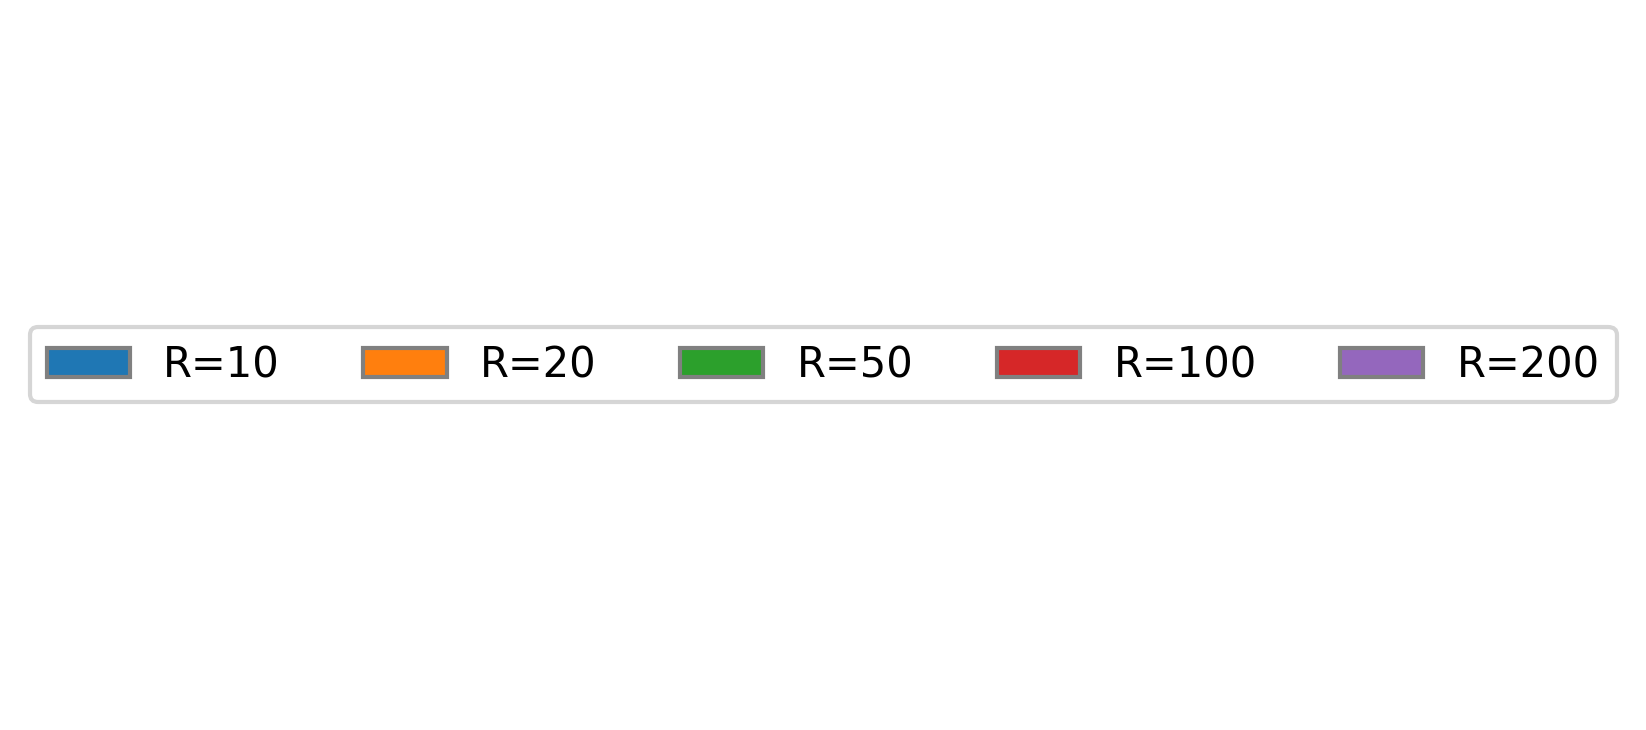

In [150]:
if cycle_model == 0:
    plot_kl_divergence(Ki67_negative_kl_divergence, "Ki67_neg_pop_NC")
    plot_kl_divergence(Ki67_positive_premitotic_kl_divergence, "Ki67_pos_pre_pop_NC")
    plot_kl_divergence(Ki67_positive_postmitotic_kl_divergence, "Ki67_pos_post_pop_NC")
elif cycle_model == 1:
    plot_kl_divergence(Ki67_negative_kl_divergence, "Ki67_neg_pop_NC")
    plot_kl_divergence(Ki67_positive_kl_divergence, "Ki67_pos_pop_NC")
elif cycle_model == 2:
    plot_kl_divergence(G0G1_phase_kl_divergence, "G0G1_phase_pop_NC")
    plot_kl_divergence(S_phase_kl_divergence, "S_phase_pop_NC")
    plot_kl_divergence(G2M_phase_kl_divergence, "G2M_phase_pop_NC")
elif cycle_model == 5:
    plot_kl_divergence(live_kl_divergence, "live_pop_NC")
elif cycle_model == 6:
    plot_kl_divergence(G0G1_phase_kl_divergence, "G0G1_phase_pop_NC")
    plot_kl_divergence(S_phase_kl_divergence, "S_phase_pop_NC")
    plot_kl_divergence(G2_phase_kl_divergence, "G2_phase_pop_NC")
    plot_kl_divergence(M_phase_kl_divergence, "M_phase_pop_NC")
else:
    print("Unrecognized cell cycle model.")

## Write *.csv* output file

In [151]:
if cycle_model == 0:
    np.savetxt(os.path.join(output_folder, "Ki67_neg_pop_NC_kl_divergence.csv"), Ki67_negative_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, P, Q, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "Ki67_pos_pre_pop_NC_kl_divergence.csv"), Ki67_positive_premitotic_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, P, Q, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "Ki67_pos_post_pop_NC_kl_divergence.csv"), Ki67_positive_postmitotic_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, P, Q, KL(P||Q)", comments='')
elif cycle_model == 1:
    np.savetxt(os.path.join(output_folder, "Ki67_neg_pop_NC_kl_divergence.csv"), Ki67_negative_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, P, Q, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "Ki67_pos_pop_NC_kl_divergence.csv"), Ki67_positive_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, P, Q, KL(P||Q)", comments='')
elif cycle_model == 2:
    np.savetxt(os.path.join(output_folder, "G0G1_phase_pop_NC_kl_divergence.csv"), G0G1_phase_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, P, Q, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "S_phase_pop_NC_kl_divergence.csv"), S_phase_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, P, Q, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "G2M_phase_pop_NC_kl_divergence.csv"), G2M_phase_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, P, Q, KL(P||Q)", comments='')
elif cycle_model == 5:
    np.savetxt(os.path.join(output_folder, "live_pop_NC_kl_divergence.csv"), live_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, P, Q, KL(P||Q)", comments='')
elif cycle_model == 6:
    np.savetxt(os.path.join(output_folder, "G0G1_phase_pop_NC_kl_divergence.csv"), G0G1_phase_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, P, Q, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "S_phase_pop_NC_kl_divergence.csv"), S_phase_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, P, Q, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "G2_phase_pop_NC_kl_divergence.csv"), G2_phase_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, P, Q, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "M_phase_pop_NC_kl_divergence.csv"), M_phase_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, P, Q, KL(P||Q)", comments='')
else:
    print("Unrecognized cell cycle model.")

## Compute Kullback-Leibler divergence for the distribution of the tumor cell fraction at the final simulation time

In [152]:
if cycle_model == 0:
    Ki67_negative_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
    Ki67_positive_premitotic_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
    Ki67_positive_postmitotic_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
elif cycle_model == 1:
    Ki67_negative_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
    Ki67_positive_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
elif cycle_model == 2:
    G0G1_phase_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
    S_phase_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
    G2M_phase_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
elif cycle_model == 5:
    live_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
elif cycle_model == 6:
    G0G1_phase_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
    S_phase_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
    G2_phase_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
    M_phase_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
else:
    print("Unrecognized cell cycle model.")

for i in range(num_unique_NC):
    if i == 0:
        indices = NC100_indices
    elif i == 1:
        indices = NC500_indices
    elif i == 2:
        indices = NC1000_indices
    
    for j, ind in enumerate(indices):
        k = i*num_kl_divergence + j
            
        if cycle_model == 0:
            Ki67_negative_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], settings[indices[-1],2], 
                                                          smoothed_hist_kl_divergence(Ki67_negative_fraction[ind][:,-1], Ki67_negative_fraction[indices[-1]][:,-1])])
            Ki67_positive_premitotic_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], settings[indices[-1],2], 
                                                          smoothed_hist_kl_divergence(Ki67_positive_premitotic_fraction[ind][:,-1], Ki67_positive_premitotic_fraction[indices[-1]][:,-1])])
            Ki67_positive_postmitotic_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], settings[indices[-1],2], 
                                                          smoothed_hist_kl_divergence(Ki67_positive_postmitotic_fraction[ind][:,-1], Ki67_positive_postmitotic_fraction[indices[-1]][:,-1])])
        elif cycle_model == 1:
            Ki67_negative_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], settings[indices[-1],2], 
                                                          smoothed_hist_kl_divergence(Ki67_negative_fraction[ind][:,-1], Ki67_negative_fraction[indices[-1]][:,-1])])
            Ki67_positive_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], settings[indices[-1],2], 
                                                          smoothed_hist_kl_divergence(Ki67_positive_fraction[ind][:,-1], Ki67_positive_fraction[indices[-1]][:,-1])])
        elif cycle_model == 2:
            G0G1_phase_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], settings[indices[-1],2], 
                                                          smoothed_hist_kl_divergence(G0G1_phase_fraction[ind][:,-1], G0G1_phase_fraction[indices[-1]][:,-1])])
            S_phase_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], settings[indices[-1],2], 
                                                          smoothed_hist_kl_divergence(S_phase_fraction[ind][:,-1], S_phase_fraction[indices[-1]][:,-1])])
            G2M_phase_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], settings[indices[-1],2], 
                                                          smoothed_hist_kl_divergence(G2M_phase_fraction[ind][:,-1], G2M_phase_fraction[indices[-1]][:,-1])])
        elif cycle_model == 5:
            live_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], settings[indices[-1],2], 
                                                          smoothed_hist_kl_divergence(live_fraction[ind][:,-1], live_fraction[indices[-1]][:,-1])])
        elif cycle_model == 6:
            G0G1_phase_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], settings[indices[-1],2], 
                                                          smoothed_hist_kl_divergence(G0G1_phase_fraction[ind][:,-1], G0G1_phase_fraction[indices[-1]][:,-1])])
            S_phase_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], settings[indices[-1],2], 
                                                          smoothed_hist_kl_divergence(S_phase_fraction[ind][:,-1], S_phase_fraction[indices[-1]][:,-1])])
            G2_phase_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], settings[indices[-1],2], 
                                                          smoothed_hist_kl_divergence(G2_phase_fraction[ind][:,-1], G2_phase_fraction[indices[-1]][:,-1])])
            M_phase_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], settings[indices[-1],2], 
                                                          smoothed_hist_kl_divergence(M_phase_fraction[ind][:,-1], M_phase_fraction[indices[-1]][:,-1])])
        else:
            print("Unrecognized cell cycle model.")

## Plot Kullback-Leibler divergence for the distribution of the tumor cell fraction at the final simulation time

<Figure size 432x288 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

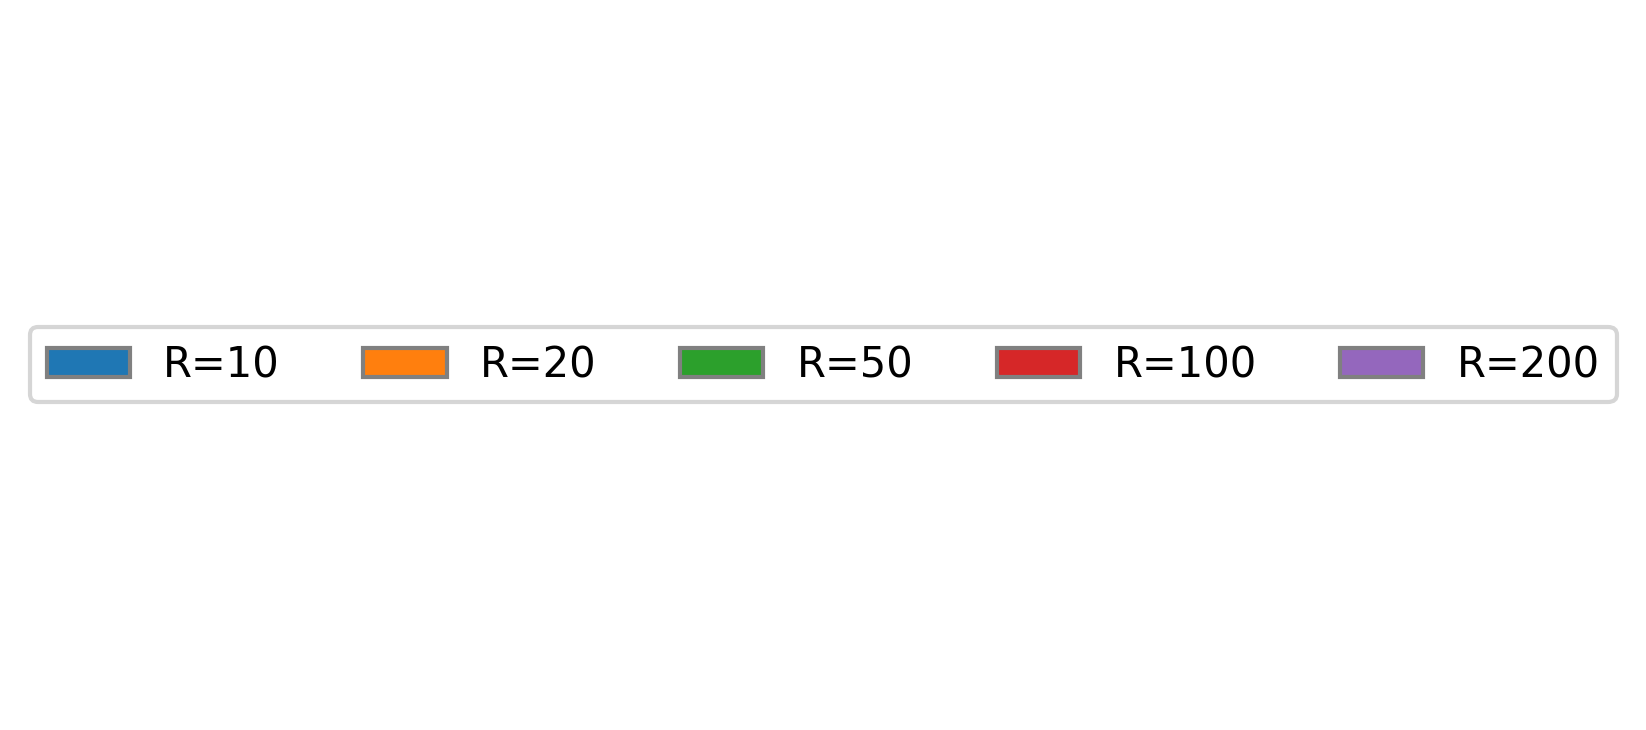

In [153]:
if cycle_model == 0:
    plot_kl_divergence(Ki67_negative_kl_divergence, "Ki67_neg_frac_NC")
    plot_kl_divergence(Ki67_positive_premitotic_kl_divergence, "Ki67_pos_pre_frac_NC")
    plot_kl_divergence(Ki67_positive_postmitotic_kl_divergence, "Ki67_pos_post_frac_NC")
elif cycle_model == 1:
    plot_kl_divergence(Ki67_negative_kl_divergence, "Ki67_neg_frac_NC")
    plot_kl_divergence(Ki67_positive_kl_divergence, "Ki67_pos_frac_NC")
elif cycle_model == 2:
    plot_kl_divergence(G0G1_phase_kl_divergence, "G0G1_phase_frac_NC")
    plot_kl_divergence(S_phase_kl_divergence, "S_phase_frac_NC")
    plot_kl_divergence(G2M_phase_kl_divergence, "G2M_phase_frac_NC")
elif cycle_model == 5:
    plot_kl_divergence(live_kl_divergence, "live_frac_NC")
elif cycle_model == 6:
    plot_kl_divergence(G0G1_phase_kl_divergence, "G0G1_phase_frac_NC")
    plot_kl_divergence(S_phase_kl_divergence, "S_phase_frac_NC")
    plot_kl_divergence(G2_phase_kl_divergence, "G2_phase_frac_NC")
    plot_kl_divergence(M_phase_kl_divergence, "M_phase_frac_NC")
else:
    print("Unrecognized cell cycle model.")

## Write *.csv* output file

In [154]:
if cycle_model == 0:
    np.savetxt(os.path.join(output_folder, "Ki67_neg_frac_NC_kl_divergence.csv"), Ki67_negative_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, P, Q, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "Ki67_pos_pre_frac_NC_kl_divergence.csv"), Ki67_positive_premitotic_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, P, Q, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "Ki67_pos_post_frac_NC_kl_divergence.csv"), Ki67_positive_postmitotic_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, P, Q, KL(P||Q)", comments='')
elif cycle_model == 1:
    np.savetxt(os.path.join(output_folder, "Ki67_neg_frac_NC_kl_divergence.csv"), Ki67_negative_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, P, Q, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "Ki67_pos_frac_NC_kl_divergence.csv"), Ki67_positive_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, P, Q, KL(P||Q)", comments='')
elif cycle_model == 2:
    np.savetxt(os.path.join(output_folder, "G0G1_phase_frac_NC_kl_divergence.csv"), G0G1_phase_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, P, Q, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "S_phase_frac_NC_kl_divergence.csv"), S_phase_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, P, Q, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "G2M_phase_frac_NC_kl_divergence.csv"), G2M_phase_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, P, Q, KL(P||Q)", comments='')
elif cycle_model == 5:
    np.savetxt(os.path.join(output_folder, "live_frac_NC_kl_divergence.csv"), live_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, P, Q, KL(P||Q)", comments='')
elif cycle_model == 6:
    np.savetxt(os.path.join(output_folder, "G0G1_phase_frac_NC_kl_divergence.csv"), G0G1_phase_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, P, Q, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "S_phase_frac_NC_kl_divergence.csv"), S_phase_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, P, Q, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "G2_phase_frac_NC_kl_divergence.csv"), G2_phase_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, P, Q, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "M_phase_frac_NC_kl_divergence.csv"), M_phase_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, P, Q, KL(P||Q)", comments='')
else:
    print("Unrecognized cell cycle model.")

## Compute Kullback-Leibler divergence for the distribution of the tumor cell fraction at the final simulation time

In [155]:
num_unique_R = len(np.unique(settings[:,2]))
num_kl_divergence = len(np.unique(settings[:,1]))
num_columns = 4

R10_indices = np.where(settings[:,2] == 10)[0]
R20_indices = np.where(settings[:,2] == 20)[0]
R50_indices = np.where(settings[:,2] == 50)[0]
R100_indices = np.where(settings[:,2] == 100)[0]
R200_indices = np.where(settings[:,2] == 200)[0]
R300_indices = np.where(settings[:,2] == 300)[0]

if cycle_model == 0:
    Ki67_negative_kl_divergence = np.zeros((num_unique_R*num_kl_divergence, num_columns))
    Ki67_positive_premitotic_kl_divergence = np.zeros((num_unique_R*num_kl_divergence, num_columns))
    Ki67_positive_postmitotic_kl_divergence = np.zeros((num_unique_R*num_kl_divergence, num_columns))
elif cycle_model == 1:
    Ki67_negative_kl_divergence = np.zeros((num_unique_R*num_kl_divergence, num_columns))
    Ki67_positive_kl_divergence = np.zeros((num_unique_R*num_kl_divergence, num_columns))
elif cycle_model == 2:
    G0G1_phase_kl_divergence = np.zeros((num_unique_R*num_kl_divergence, num_columns))
    S_phase_kl_divergence = np.zeros((num_unique_R*num_kl_divergence, num_columns))
    G2M_phase_kl_divergence = np.zeros((num_unique_R*num_kl_divergence, num_columns))
elif cycle_model == 5:
    live_kl_divergence = np.zeros((num_unique_R*num_kl_divergence, num_columns))
elif cycle_model == 6:
    G0G1_phase_kl_divergence = np.zeros((num_unique_R*num_kl_divergence, num_columns))
    S_phase_kl_divergence = np.zeros((num_unique_R*num_kl_divergence, num_columns))
    G2_phase_kl_divergence = np.zeros((num_unique_R*num_kl_divergence, num_columns))
    M_phase_kl_divergence = np.zeros((num_unique_R*num_kl_divergence, num_columns))
else:
    print("Unrecognized cell cycle model.")

for i in range(num_unique_R):
    if i == 0:
        indices = R10_indices
    elif i == 1:
        indices = R20_indices
    elif i == 2:
        indices = R50_indices
    elif i == 3:
        indices = R100_indices
    elif i == 4:
        indices = R200_indices
    elif i == 5:
        indices = R300_indices
    
    for j, ind in enumerate(indices):
        k = i*num_kl_divergence + j
            
        if cycle_model == 0:
            Ki67_negative_kl_divergence[k,:] = np.array([settings[ind,2], settings[ind,1], settings[indices[-1],1], 
                                                          smoothed_hist_kl_divergence(Ki67_negative_fraction[ind][:,-1], Ki67_negative_fraction[indices[-1]][:,-1])])
            Ki67_positive_premitotic_kl_divergence[k,:] = np.array([settings[ind,2], settings[ind,1], settings[indices[-1],1], 
                                                          smoothed_hist_kl_divergence(Ki67_positive_premitotic_fraction[ind][:,-1], Ki67_positive_premitotic_fraction[indices[-1]][:,-1])])
            Ki67_positive_postmitotic_kl_divergence[k,:] = np.array([settings[ind,2], settings[ind,1], settings[indices[-1],1], 
                                                          smoothed_hist_kl_divergence(Ki67_positive_postmitotic_fraction[ind][:,-1], Ki67_positive_postmitotic_fraction[indices[-1]][:,-1])])
        elif cycle_model == 1:
            Ki67_negative_kl_divergence[k,:] = np.array([settings[ind,2], settings[ind,1], settings[indices[-1],1], 
                                                          smoothed_hist_kl_divergence(Ki67_negative_fraction[ind][:,-1], Ki67_negative_fraction[indices[-1]][:,-1])])
            Ki67_positive_kl_divergence[k,:] = np.array([settings[ind,2], settings[ind,1], settings[indices[-1],1], 
                                                          smoothed_hist_kl_divergence(Ki67_positive_fraction[ind][:,-1], Ki67_positive_fraction[indices[-1]][:,-1])])
        elif cycle_model == 2:
            G0G1_phase_kl_divergence[k,:] = np.array([settings[ind,2], settings[ind,1], settings[indices[-1],1], 
                                                          smoothed_hist_kl_divergence(G0G1_phase_fraction[ind][:,-1], G0G1_phase_fraction[indices[-1]][:,-1])])
            S_phase_kl_divergence[k,:] = np.array([settings[ind,2], settings[ind,1], settings[indices[-1],1], 
                                                          smoothed_hist_kl_divergence(S_phase_fraction[ind][:,-1], S_phase_fraction[indices[-1]][:,-1])])
            G2M_phase_kl_divergence[k,:] = np.array([settings[ind,2], settings[ind,1], settings[indices[-1],1], 
                                                          smoothed_hist_kl_divergence(G2M_phase_fraction[ind][:,-1], G2M_phase_fraction[indices[-1]][:,-1])])
        elif cycle_model == 5:
            live_kl_divergence[k,:] = np.array([settings[ind,2], settings[ind,1], settings[indices[-1],1], 
                                                          smoothed_hist_kl_divergence(live_fraction[ind][:,-1], live_fraction[indices[-1]][:,-1])])
        elif cycle_model == 6:
            G0G1_phase_kl_divergence[k,:] = np.array([settings[ind,2], settings[ind,1], settings[indices[-1],1], 
                                                          smoothed_hist_kl_divergence(G0G1_phase_fraction[ind][:,-1], G0G1_phase_fraction[indices[-1]][:,-1])])
            S_phase_kl_divergence[k,:] = np.array([settings[ind,2], settings[ind,1], settings[indices[-1],1], 
                                                          smoothed_hist_kl_divergence(S_phase_fraction[ind][:,-1], S_phase_fraction[indices[-1]][:,-1])])
            G2_phase_kl_divergence[k,:] = np.array([settings[ind,2], settings[ind,1], settings[indices[-1],1], 
                                                          smoothed_hist_kl_divergence(G2_phase_fraction[ind][:,-1], G2_phase_fraction[indices[-1]][:,-1])])
            M_phase_kl_divergence[k,:] = np.array([settings[ind,2], settings[ind,1], settings[indices[-1],1], 
                                                          smoothed_hist_kl_divergence(M_phase_fraction[ind][:,-1], M_phase_fraction[indices[-1]][:,-1])])
        else:
            print("Unrecognized cell cycle model.")

## Plot Kullback-Leibler divergence for the distribution of the tumor cell fraction at the final simulation time

In [156]:
def plot_kl_divergence(tumor_cell_kl_divergence, cell_cycle_phase_filename, bar_width = 0.25, ticks_factor = 0.5):
    bar_data = np.split(tumor_cell_kl_divergence[:,-1], num_unique_R)
    for i in range(num_unique_R):
        bar_data[i] = bar_data[i][0:num_kl_divergence-1]
    bar_data = np.array(bar_data).T.tolist()

    bar_pos = [None] * len(bar_data)
    bar_pos[0] = np.arange(len(bar_data[0]))
    for i in range(1, len(bar_data)):
        bar_pos[i] = np.array([x + bar_width for x in bar_pos[i-1]])

    bars = []
    labels = ["NC=" + str(int(i)) for i in np.unique(settings[:,1])]
    labels = labels[0:num_kl_divergence-1]
    ticks = np.unique(settings[:,2]).astype(int)

    plt.clf()
    plt.subplots(1, 1, figsize = (5.27, 2.96), dpi = 300)
    for i in range(len(bar_data)):
        bar = plt.bar(bar_pos[i], bar_data[i], width=bar_width, edgecolor='grey', label=labels[i])
        bars.append(bar)
    # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.xticks([r + ticks_factor*bar_width for r in range(len(bar_data[0]))], ticks)
    # plt.xlabel( 'Number of replicates', size=15 ) 
    # plt.ylabel( 'KL divergence', size=15 )
    plt.yscale( 'log' )
    plt.savefig(os.path.join(output_folder, cell_cycle_phase_filename + "_kl_divergence.pdf"), bbox_inches = 'tight')
    
    plt.clf()
    plt.subplots(1, 1, figsize = (5.27, 2.96), dpi = 300)
    plt.legend(bars, labels, loc='center', ncol=5)
    plt.axis('off')
    plt.savefig(os.path.join(output_folder, cell_cycle_phase_filename + "_kl_divergence_legend.pdf"), bbox_inches = 'tight')

<Figure size 432x288 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

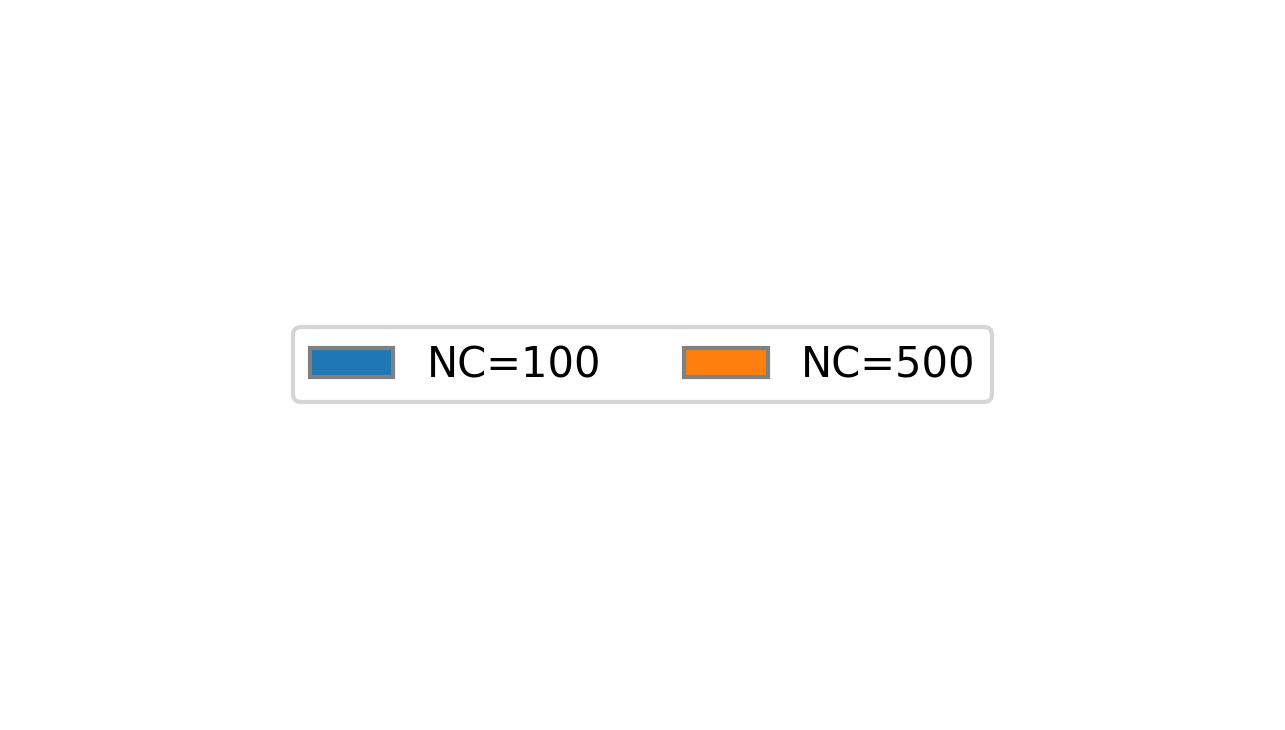

In [157]:
if cycle_model == 0:
    plot_kl_divergence(Ki67_negative_kl_divergence, "Ki67_neg_frac_R")
    plot_kl_divergence(Ki67_positive_premitotic_kl_divergence, "Ki67_pos_pre_frac_R")
    plot_kl_divergence(Ki67_positive_postmitotic_kl_divergence, "Ki67_pos_post_frac_R")
elif cycle_model == 1:
    plot_kl_divergence(Ki67_negative_kl_divergence, "Ki67_neg_frac_R")
    plot_kl_divergence(Ki67_positive_kl_divergence, "Ki67_pos_frac_R")
elif cycle_model == 2:
    plot_kl_divergence(G0G1_phase_kl_divergence, "G0G1_phase_frac_R")
    plot_kl_divergence(S_phase_kl_divergence, "S_phase_frac_R")
    plot_kl_divergence(G2M_phase_kl_divergence, "G2M_phase_frac_R")
elif cycle_model == 5:
    plot_kl_divergence(live_kl_divergence, "live_frac_R")
elif cycle_model == 6:
    plot_kl_divergence(G0G1_phase_kl_divergence, "G0G1_phase_frac_R")
    plot_kl_divergence(S_phase_kl_divergence, "S_phase_frac_R")
    plot_kl_divergence(G2_phase_kl_divergence, "G2_phase_frac_R")
    plot_kl_divergence(M_phase_kl_divergence, "M_phase_frac_R")
else:
    print("Unrecognized cell cycle model.")

## Write *.csv* output file

In [158]:
if cycle_model == 0:
    np.savetxt(os.path.join(output_folder, "Ki67_neg_frac_R_kl_divergence.csv"), Ki67_negative_kl_divergence, delimiter=',', fmt='%.8f',
               header="R, P, Q, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "Ki67_pos_pre_frac_R_kl_divergence.csv"), Ki67_positive_premitotic_kl_divergence, delimiter=',', fmt='%.8f',
               header="R, P, Q, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "Ki67_pos_post_frac_R_kl_divergence.csv"), Ki67_positive_postmitotic_kl_divergence, delimiter=',', fmt='%.8f',
               header="R, P, Q, KL(P||Q)", comments='')
elif cycle_model == 1:
    np.savetxt(os.path.join(output_folder, "Ki67_neg_frac_R_kl_divergence.csv"), Ki67_negative_kl_divergence, delimiter=',', fmt='%.8f',
               header="R, P, Q, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "Ki67_pos_frac_R_kl_divergence.csv"), Ki67_positive_kl_divergence, delimiter=',', fmt='%.8f',
               header="R, P, Q, KL(P||Q)", comments='')
elif cycle_model == 2:
    np.savetxt(os.path.join(output_folder, "G0G1_phase_frac_R_kl_divergence.csv"), G0G1_phase_kl_divergence, delimiter=',', fmt='%.8f',
               header="R, P, Q, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "S_phase_frac_R_kl_divergence.csv"), S_phase_kl_divergence, delimiter=',', fmt='%.8f',
               header="R, P, Q, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "G2M_phase_frac_R_kl_divergence.csv"), G2M_phase_kl_divergence, delimiter=',', fmt='%.8f',
               header="R, P, Q, KL(P||Q)", comments='')
elif cycle_model == 5:
    np.savetxt(os.path.join(output_folder, "live_frac_R_kl_divergence.csv"), live_kl_divergence, delimiter=',', fmt='%.8f',
               header="R, P, Q, KL(P||Q)", comments='')
elif cycle_model == 6:
    np.savetxt(os.path.join(output_folder, "G0G1_phase_frac_R_kl_divergence.csv"), G0G1_phase_kl_divergence, delimiter=',', fmt='%.8f',
               header="R, P, Q, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "S_phase_frac_R_kl_divergence.csv"), S_phase_kl_divergence, delimiter=',', fmt='%.8f',
               header="R, P, Q, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "G2_phase_frac_R_kl_divergence.csv"), G2_phase_kl_divergence, delimiter=',', fmt='%.8f',
               header="R, P, Q, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "M_phase_frac_R_kl_divergence.csv"), M_phase_kl_divergence, delimiter=',', fmt='%.8f',
               header="R, P, Q, KL(P||Q)", comments='')
else:
    print("Unrecognized cell cycle model.")

## Compute Kullback-Leibler divergence for the distribution of the tumor cell fraction at the final simulation time using the same reference

In [159]:
num_unique_NC = len(np.unique(settings[:,1]))
num_kl_divergence = len(np.unique(settings[:,2]))
num_columns = 3

NC100_indices = np.where(settings[:,1] == 100)[0]
NC500_indices = np.where(settings[:,1] == 500)[0]
NC1000_indices = np.where(settings[:,1] == 1000)[0]

if cycle_model == 0:
    Ki67_negative_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
    Ki67_positive_premitotic_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
    Ki67_positive_postmitotic_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
elif cycle_model == 1:
    Ki67_negative_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
    Ki67_positive_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
elif cycle_model == 2:
    G0G1_phase_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
    S_phase_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
    G2M_phase_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
elif cycle_model == 5:
    live_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
elif cycle_model == 6:
    G0G1_phase_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
    S_phase_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
    G2_phase_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
    M_phase_kl_divergence = np.zeros((num_unique_NC*num_kl_divergence, num_columns))
else:
    print("Unrecognized cell cycle model.")

for i in range(num_unique_NC):
    if i == 0:
        indices = NC100_indices
    elif i == 1:
        indices = NC500_indices
    elif i == 2:
        indices = NC1000_indices
    
    for j, ind in enumerate(indices):
        k = i*num_kl_divergence + j
            
        if cycle_model == 0:
            Ki67_negative_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], 
                                                          smoothed_hist_kl_divergence(Ki67_negative_fraction[ind][:,-1], Ki67_negative_fraction[NC1000_indices[-1]][:,-1])])
            Ki67_positive_premitotic_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], 
                                                          smoothed_hist_kl_divergence(Ki67_positive_premitotic_fraction[ind][:,-1], Ki67_positive_premitotic_fraction[NC1000_indices[-1]][:,-1])])
            Ki67_positive_postmitotic_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], 
                                                          smoothed_hist_kl_divergence(Ki67_positive_postmitotic_fraction[ind][:,-1], Ki67_positive_postmitotic_fraction[NC1000_indices[-1]][:,-1])])
        elif cycle_model == 1:
            Ki67_negative_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], 
                                                          smoothed_hist_kl_divergence(Ki67_negative_fraction[ind][:,-1], Ki67_negative_fraction[NC1000_indices[-1]][:,-1])])
            Ki67_positive_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], 
                                                          smoothed_hist_kl_divergence(Ki67_positive_fraction[ind][:,-1], Ki67_positive_fraction[NC1000_indices[-1]][:,-1])])
        elif cycle_model == 2:
            G0G1_phase_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], 
                                                          smoothed_hist_kl_divergence(G0G1_phase_fraction[ind][:,-1], G0G1_phase_fraction[NC1000_indices[-1]][:,-1])])
            S_phase_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], 
                                                          smoothed_hist_kl_divergence(S_phase_fraction[ind][:,-1], S_phase_fraction[NC1000_indices[-1]][:,-1])])
            G2M_phase_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], 
                                                          smoothed_hist_kl_divergence(G2M_phase_fraction[ind][:,-1], G2M_phase_fraction[NC1000_indices[-1]][:,-1])])
        elif cycle_model == 5:
            live_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], 
                                                          smoothed_hist_kl_divergence(live_fraction[ind][:,-1], live_fraction[NC1000_indices[-1]][:,-1])])
        elif cycle_model == 6:
            G0G1_phase_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], 
                                                          smoothed_hist_kl_divergence(G0G1_phase_fraction[ind][:,-1], G0G1_phase_fraction[NC1000_indices[-1]][:,-1])])
            S_phase_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], 
                                                          smoothed_hist_kl_divergence(S_phase_fraction[ind][:,-1], S_phase_fraction[NC1000_indices[-1]][:,-1])])
            G2_phase_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], 
                                                          smoothed_hist_kl_divergence(G2_phase_fraction[ind][:,-1], G2_phase_fraction[NC1000_indices[-1]][:,-1])])
            M_phase_kl_divergence[k,:] = np.array([settings[ind,1], settings[ind,2], 
                                                          smoothed_hist_kl_divergence(M_phase_fraction[ind][:,-1], M_phase_fraction[NC1000_indices[-1]][:,-1])])
        else:
            print("Unrecognized cell cycle model.")

## Plot Kullback-Leibler divergence for the distribution of the tumor cell fraction at the final simulation time using the same reference

In [160]:
def heatmap(data, row_labels, col_labels, ax=None, cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    im_ratio = data.shape[0]/data.shape[1]
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046*im_ratio, pad=0.04, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    # plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
    # 		 rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar

def annotate_heatmap(im, data=None, valfmt="{x:.2f}", textcolors=("black", "white"), threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            # kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [161]:
number_of_cells = np.unique(settings[:,1])
num_replicates = np.unique(settings[:,2])

number_of_cells_labels = number_of_cells.astype(int).astype(str)
num_replicates_labels = num_replicates.astype(int).astype(str)

if cycle_model == 0:
    Ki67_negative_kl_divergence_heatmap = Ki67_negative_kl_divergence[:,-1]
    Ki67_positive_premitotic_kl_divergence_heatmap = Ki67_positive_premitotic_kl_divergence[:,-1]
    Ki67_positive_postmitotic_kl_divergence_heatmap = Ki67_positive_postmitotic_kl_divergence[:,-1]
    
    Ki67_negative_kl_divergence_heatmap = Ki67_negative_kl_divergence_heatmap.reshape((len(number_of_cells), len(num_replicates)))
    Ki67_positive_premitotic_kl_divergence_heatmap = Ki67_positive_premitotic_kl_divergence_heatmap.reshape((len(number_of_cells), len(num_replicates)))
    Ki67_positive_postmitotic_kl_divergence_heatmap = Ki67_positive_postmitotic_kl_divergence_heatmap.reshape((len(number_of_cells), len(num_replicates)))
    
    Ki67_negative_kl_divergence_heatmap = np.transpose(Ki67_negative_kl_divergence_heatmap)
    Ki67_positive_premitotic_kl_divergence_heatmap = np.transpose(Ki67_positive_premitotic_kl_divergence_heatmap)
    Ki67_positive_postmitotic_kl_divergence_heatmap = np.transpose(Ki67_positive_postmitotic_kl_divergence_heatmap)
elif cycle_model == 1:
    Ki67_negative_kl_divergence_heatmap = Ki67_negative_kl_divergence[:,-1]
    Ki67_positive_kl_divergence_heatmap = Ki67_positive_kl_divergence[:,-1]
    
    Ki67_negative_kl_divergence_heatmap = Ki67_negative_kl_divergence_heatmap.reshape((len(number_of_cells), len(num_replicates)))
    Ki67_positive_kl_divergence_heatmap = Ki67_positive_kl_divergence_heatmap.reshape((len(number_of_cells), len(num_replicates)))
    
    Ki67_negative_kl_divergence_heatmap = np.transpose(Ki67_negative_kl_divergence_heatmap)
    Ki67_positive_kl_divergence_heatmap = np.transpose(Ki67_positive_kl_divergence_heatmap)
elif cycle_model == 2:
    G0G1_phase_kl_divergence_heatmap = G0G1_phase_kl_divergence[:,-1]
    S_phase_kl_divergence_heatmap = S_phase_kl_divergence[:,-1]
    G2M_phase_kl_divergence_heatmap = G2M_phase_kl_divergence[:,-1]
    
    G0G1_phase_kl_divergence_heatmap = G0G1_phase_kl_divergence_heatmap.reshape((len(number_of_cells), len(num_replicates)))
    S_phase_kl_divergence_heatmap = S_phase_kl_divergence_heatmap.reshape((len(number_of_cells), len(num_replicates)))
    G2M_phase_kl_divergence_heatmap = G2M_phase_kl_divergence_heatmap.reshape((len(number_of_cells), len(num_replicates)))
    
    G0G1_phase_kl_divergence_heatmap = np.transpose(G0G1_phase_kl_divergence_heatmap)
    S_phase_kl_divergence_heatmap = np.transpose(S_phase_kl_divergence_heatmap)
    G2M_phase_kl_divergence_heatmap = np.transpose(G2M_phase_kl_divergence_heatmap)
elif cycle_model == 5:
    live_kl_divergence_heatmap = live_kl_divergence[:,-1]
    
    live_kl_divergence_heatmap = live_kl_divergence_heatmap.reshape((len(number_of_cells), len(num_replicates)))
    
    live_kl_divergence_heatmap = np.transpose(live_kl_divergence_heatmap)
elif cycle_model == 6:
    G0G1_phase_kl_divergence_heatmap = G0G1_phase_kl_divergence[:,-1]
    S_phase_kl_divergence_heatmap = S_phase_kl_divergence[:,-1]
    G2_phase_kl_divergence_heatmap = G2_phase_kl_divergence[:,-1]
    M_phase_kl_divergence_heatmap = M_phase_kl_divergence[:,-1]
    
    G0G1_phase_kl_divergence_heatmap = G0G1_phase_kl_divergence_heatmap.reshape((len(number_of_cells), len(num_replicates)))
    S_phase_kl_divergence_heatmap = S_phase_kl_divergence_heatmap.reshape((len(number_of_cells), len(num_replicates)))
    G2_phase_kl_divergence_heatmap = G2_phase_kl_divergence_heatmap.reshape((len(number_of_cells), len(num_replicates)))
    M_phase_kl_divergence_heatmap = M_phase_kl_divergence_heatmap.reshape((len(number_of_cells), len(num_replicates)))
    
    G0G1_phase_kl_divergence_heatmap = np.transpose(G0G1_phase_kl_divergence_heatmap)
    S_phase_kl_divergence_heatmap = np.transpose(S_phase_kl_divergence_heatmap)
    G2_phase_kl_divergence_heatmap = np.transpose(G2_phase_kl_divergence_heatmap)
    M_phase_kl_divergence_heatmap = np.transpose(M_phase_kl_divergence_heatmap)
else:
    print("Unrecognized cell cycle model.")

In [162]:
def plot_heatmap(heatmap_data, cell_cycle_phase_filename):
    plt.clf()
    fig, ax = plt.subplots(1, 1, figsize = (5.27, 2.96), dpi = 300)
    im, cbar = heatmap(heatmap_data, num_replicates_labels, number_of_cells_labels, ax=ax, cmap="Greens", norm=matplotlib.colors.LogNorm(vmin=1.0e-3, vmax=1.0e1)) #cbarlabel="KL divergence",
    cbar.remove()
    # texts = annotate_heatmap(im, valfmt="{x:.1f}")

    # plt.xlabel( "Initial number of cells", size=10 )
    ax.xaxis.set_label_position('top') 
    # plt.ylabel( "Number of replicates", size=10 )
    plt.savefig(os.path.join(output_folder, cell_cycle_phase_filename + "_kl_divergence_same_ref.pdf"), bbox_inches = 'tight')
    
    plt.clf()
    fig, ax = plt.subplots(1, 1, figsize = (1.48, 2.96), dpi = 300)
    
    im_ratio = heatmap_data.shape[0]/heatmap_data.shape[1]
    cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046*im_ratio, pad=0.04, cmap="Greens", norm=matplotlib.colors.LogNorm(vmin=1.0e-3, vmax=1.0e1))
    plt.gca().set_visible(False)
    
    plt.savefig(os.path.join(output_folder, cell_cycle_phase_filename + "_kl_divergence_same_ref_colorbar.pdf"), bbox_inches = 'tight')

<Figure size 432x288 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 444x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 444x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

<Figure size 444x888 with 0 Axes>

<Figure size 1581x888 with 0 Axes>

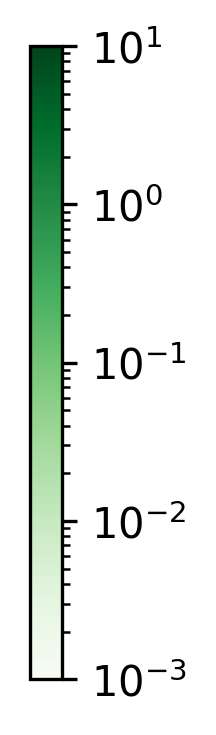

In [163]:
if cycle_model == 0:
    plot_heatmap(Ki67_negative_kl_divergence_heatmap, "Ki67_neg_frac")
    plot_heatmap(Ki67_positive_premitotic_kl_divergence_heatmap, "Ki67_pos_pre_frac")
    plot_heatmap(Ki67_positive_postmitotic_kl_divergence_heatmap, "Ki67_pos_post_frac")
elif cycle_model == 1:
    plot_heatmap(Ki67_negative_kl_divergence_heatmap, "Ki67_neg_frac")
    plot_heatmap(Ki67_positive_kl_divergence_heatmap, "Ki67_pos_frac")
elif cycle_model == 2:
    plot_heatmap(G0G1_phase_kl_divergence_heatmap, "G0G1_phase_frac")
    plot_heatmap(S_phase_kl_divergence_heatmap, "S_phase_frac")
    plot_heatmap(G2M_phase_kl_divergence_heatmap, "G2M_phase_frac")
elif cycle_model == 5:
    plot_heatmap(live_kl_divergence_heatmap, "live_frac")
elif cycle_model == 6:
    plot_heatmap(G0G1_phase_kl_divergence_heatmap, "G0G1_phase_frac")
    plot_heatmap(S_phase_kl_divergence_heatmap, "S_phase_frac")
    plot_heatmap(G2_phase_kl_divergence_heatmap, "G2_phase_frac")
    plot_heatmap(M_phase_kl_divergence_heatmap, "M_phase_frac")
else:
    print("Unrecognized cell cycle model.")

## Write *.csv* output file

In [164]:
if cycle_model == 0:
    np.savetxt(os.path.join(output_folder, "Ki67_neg_frac_NC_kl_divergence_same_ref.csv"), Ki67_negative_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, R, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "Ki67_pos_pre_frac_NC_kl_divergence_same_ref.csv"), Ki67_positive_premitotic_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, R, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "Ki67_pos_post_frac_NC_kl_divergence_same_ref.csv"), Ki67_positive_postmitotic_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, R, KL(P||Q)", comments='')
elif cycle_model == 1:
    np.savetxt(os.path.join(output_folder, "Ki67_neg_frac_NC_kl_divergence_same_ref.csv"), Ki67_negative_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, R, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "Ki67_pos_frac_NC_kl_divergence_same_ref.csv"), Ki67_positive_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, R, KL(P||Q)", comments='')
elif cycle_model == 2:
    np.savetxt(os.path.join(output_folder, "G0G1_phase_frac_NC_kl_divergence_same_ref.csv"), G0G1_phase_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, R, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "S_phase_frac_NC_kl_divergence_same_ref.csv"), S_phase_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, R, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "G2M_phase_frac_NC_kl_divergence_same_ref.csv"), G2M_phase_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, R, KL(P||Q)", comments='')
elif cycle_model == 5:
    np.savetxt(os.path.join(output_folder, "live_frac_NC_kl_divergence_same_ref.csv"), live_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, R, KL(P||Q)", comments='')
elif cycle_model == 6:
    np.savetxt(os.path.join(output_folder, "G0G1_phase_frac_NC_kl_divergence_same_ref.csv"), G0G1_phase_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, R, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "S_phase_frac_NC_kl_divergence_same_ref.csv"), S_phase_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, R, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "G2_phase_frac_NC_kl_divergence_same_ref.csv"), G2_phase_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, R, KL(P||Q)", comments='')
    np.savetxt(os.path.join(output_folder, "M_phase_frac_NC_kl_divergence_same_ref.csv"), M_phase_kl_divergence, delimiter=',', fmt='%.8f',
               header="NC, R, KL(P||Q)", comments='')
else:
    print("Unrecognized cell cycle model.")